In [1]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Using GLS in `R`
In the previous part of this lesson, we discussed the theory behind GLS. Now we turn to how GLS is implemented within `R`. We saw some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of *both* correlation and heterogenous variance groups. In this part of the lesson, we will explore `gls()` further using a simple repeated measures one-way ANOVA model. We will see examples of using `gls()` on more complex datasets in the workshop this week.

## The GLS One-way ANOVA

### The Data
The `datarium` package contains a dataset called `selfesteem` that contains measurements of a self-esteem score taken at 3 different time points per-subject. We can see how this is structured below

In [2]:
library('datarium')
data('selfesteem')
head(selfesteem)

  id       t1       t2       t3
1  1 4.005027 5.182286 7.107831
2  2 2.558124 6.912915 6.308434
3  3 3.244241 4.443434 9.778410
4  4 3.419538 4.711696 8.347124
5  5 2.871243 3.908429 6.457287
6  6 2.045868 5.340549 6.653224

We can then convert it to long-format to make it suitable for univariate modelling

In [3]:
library('reshape2')

# repeats and number of subjects
t <- 3
n <- dim(selfesteem)[1]

# reshape wide -> long
selfesteem.long <- melt(selfesteem,            # wide data frame
                        id.vars='id',          # what stays fixed?
                        variable.name="time",  # name for the new predictor
                        value.name="score")    # name for the new outcome

selfesteem.long <- selfesteem.long[order(selfesteem.long$id),] # order by ID
rownames(selfesteem.long) <- seq(1,n*t)                        # fix row names
selfesteem.long$id        <- as.factor(selfesteem.long$id)     # convert ID to factor

print(head(selfesteem.long))

  id time    score
1  1   t1 4.005027
2  1   t2 5.182286
3  1   t3 7.107831
4  2   t1 2.558124
5  2   t2 6.912915
6  2   t3 6.308434


Our aim will be to look at different ways of modelling the covariance structure within this dataset, using GLS. In general, because there are 3 repeated measurements, the covariance matrix for each subject will be $3 \times 3$. Because we always assume that the subject are independent, we will be working with a block-diagonal structure of the form

$$
\text{Var}\left(\boldsymbol{\epsilon}\right) = 
\begin{bmatrix}
    \boldsymbol{\Sigma}_{1} & \mathbf{0}              & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \boldsymbol{\Sigma}_{2} & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \mathbf{0}              & \boldsymbol{\Sigma}_{3} & \cdots & \mathbf{0}              \\
    \vdots                  & \vdots                  & \vdots                  & \ddots & \vdots                  \\          
    \mathbf{0}              & \mathbf{0}              & \mathbf{0}              & \cdots & \boldsymbol{\Sigma}_{n} \\
\end{bmatrix},
$$

where each $\boldsymbol{\Sigma}_{i}$ is an *identical* $3 \times 3$ matrix and each $\mathbf{0}$ is a $3 \times 3$ matrix of zeros. As such, for subject $i$, our decisions centre on how the following matrix is parameterised

$$
\boldsymbol{\Sigma}_{i} = 
\begin{bmatrix}
    \sigma^{2}_{1} & \sigma_{12}    & \sigma_{13}    \\
    \sigma_{12}    & \sigma^{2}_{2} & \sigma_{23}    \\
    \sigma_{13}    & \sigma_{23}    & \sigma^{2}_{3} \\
\end{bmatrix}.
$$

### The `gls()` Syntax
... The equivalent model to the repeated measures ANOVA would be

In [ ]:
library('nlme')
library('Matrix')

gls.mod <- gls(score ~ time, correlation=corCompSymm(form= ~1|id), data=selfesteem.long)

print(gls.mod)

Generalized least squares fit by REML
  Model: score ~ time 
  Data: selfesteem.long 
  Log-restricted-likelihood: -38.00009

Coefficients:
(Intercept)      timet2      timet3 
   3.140122    1.793820    4.496220 

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
       Rho 
-0.1765313 
Degrees of freedom: 30 total; 27 residual
Residual standard error: 0.8859852 


... We can therefore view $\hat{\boldsymbol{\Sigma}_{i}}$ for a given subject. For instance, the estimated covariance structure for the subject with `id = '1'` is

In [5]:
Sigma.1 <- getVarCov(gls.mod, individual='1') # get covariance
print(Sigma.1)


Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.78497 -0.13857 -0.13857
[2,] -0.13857  0.78497 -0.13857
[3,] -0.13857 -0.13857  0.78497
  Standard Deviations: 0.88599 0.88599 0.88599 


So here we can actually *see* the compound symmetric structure, as all the diagonal elements are the same and all the off-diagonal elements are the same. It can also be useful to *visualise* this matrix, to make the structure clear. To do so, we load the `Matrix` package to convert the output of `getVarCov()` to a `Matrix` and then visualise it with the `image` function

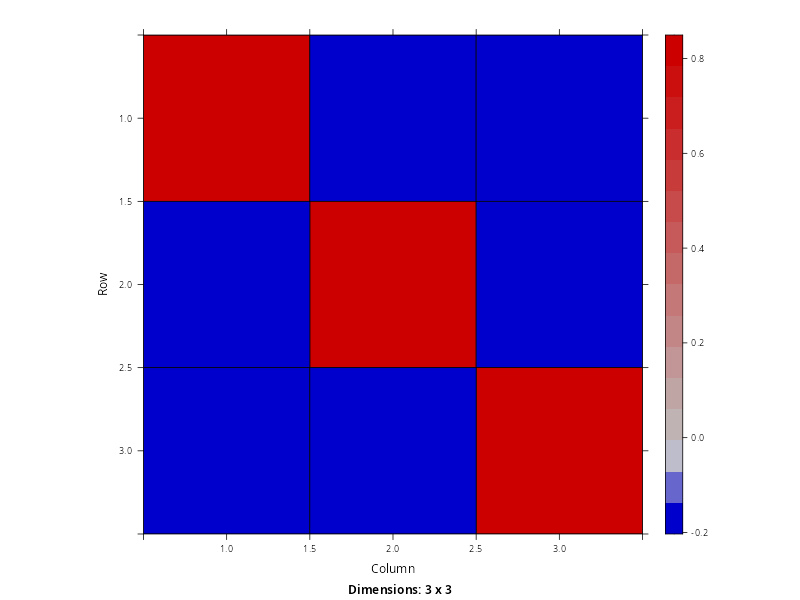

In [6]:
image(as(Sigma.1, "Matrix"))

### Understanding the `form=` Syntax
The `form=` syntax can take a little getting used to, but it is worth making an effort to understand because this is *the* way that the structure of the covariance matrix is defined. To facilitate this, we will use the `corSymm()` function as an example, because this defines a *completely unstructured* covariance matrix. As such, the way that `form=` is written will fully determine how this matrix is estimated. 

To begin with, the most basic structure would be `form= ~1|id`. Here, the factor on the *right-hand* side of `|` defines the *blocks*. So each level of `id` defines a separate independent block and we have implied a block-diagonal structure to the covariance matrix. The variable on the *left-hand* side of `|` defines the structure *within* each block. If we just use `1` here, it implies a completely *unstructured* approach where every element is estimated separately. So, `1|id` means "estimate a completely unconstrained covariance block for each subject". 

Now, imagine the situation where the repeated measurements are taken across time. If we have multiple replications at each time-point (e.g. each subject was measured 4 times at each time-point) then this provides the opportunity for additional structure. For instance, we can specify `form= ~time|id`, which still defines a blocked structure, but within each block we are saying that the variable `time` defines our *occasion* or *order*. If we do this, the covariance structure within a block will be defined in terms of `time`, so that the replications at each time-point would share a correlation. If we instead specified `form= ~1|id` then each block would be *fully unconstrained*. So, every pair of replications within each time-point would have a different correlation. This idea is visualised below for a single block (i.e. subject $i$ with covariance matrix $\boldsymbol{\Sigma}_{i}$) from an experiment with 3 time-points and 4 replications within each time-point. Hopefully this makes the distinction and its relationship with the syntax clearer.

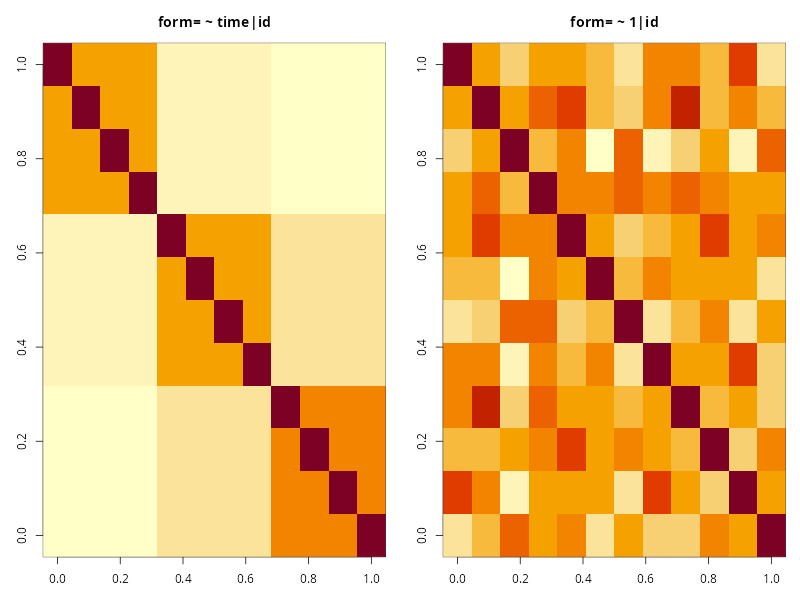

In [41]:
## Same idea as before, but using base graphics throughout

set.seed(1)

Tt   <- 3      # time points
Rrep <- 4      # replicates per time
n    <- Tt * Rrep

## ---- (A) Collapsed by time (what ~ time | id implies) ----
R_time <- matrix(c(
  1.00, 0.30, 0.10,
  0.30, 1.00, 0.20,
  0.10, 0.20, 1.00
), nrow = 3, byrow = TRUE)

rho_within <- c(0.60, 0.55, 0.50)

R_collapsed <- matrix(0, n, n)
time_index <- rep(1:Tt, each = Rrep)

for (ti in 1:Tt) {
  for (tj in 1:Tt) {
    ii <- which(time_index == ti)
    jj <- which(time_index == tj)

    if (ti == tj) {
      B <- matrix(rho_within[ti], Rrep, Rrep)
      diag(B) <- 1
      R_collapsed[ii, jj] <- B
    } else {
      R_collapsed[ii, jj] <- R_time[ti, tj]
    }
  }
}

## ---- (B) Fully unstructured across rows (~ 1 | id) ----
A <- matrix(rnorm(n * n), n, n)
S <- A %*% t(A)
R_unconstrained <- cov2cor(S)

## ---- Plot side-by-side with base graphics ----
par(mfrow = c(1, 2), mar = c(3, 3, 3, 1))

graphics::image(R_collapsed[n:1, ],
                main = "form= ~ time|id",
                xlab = "obs", ylab = "obs")

graphics::image(R_unconstrained[n:1, ],
                main = "form= ~ 1|id",
                xlab = "obs", ylab = "obs")


Note that this syntax will depend upon the type of structure used. For instance, `corCompSymm()` will ignore anything other than a `1` on the left-hand side of `|`, because a compound symmetric structure only has a single correlation for all observations within a block. So, you need to think about the *structure* you are using, how the *blocks* are defined for that structure using the term on the *right* of `|`, and how that structure is defined *within* a block using the terms on the *left* of `|`. We will see more examples of this syntax below and in the workshop this week.

### More Complex Covariance Structures
... Importantly, decisions between these structures either has to be *theoretically* motivated, or we have to use the *data* to see which structure has the most evidence in its favour. Although we can reason about the structure of this matrix, this is often quite hard to do in practice and needs quite deep knowledge of the phenomena under question. As such, it is much more typical to consider all possible *reasonable* structures and then use model comparisons to choose between them. For the moment, we will focus on the structures, but at the end of this part of the lesson we will see how to use the *data* to choose between them.

So, in terms of *reasonable* structures, we will constraint ourselves to either *fixing* all correlations to a single value (i.e. compound symmetry) or allowing all correlations to *freely vary* (i.e. an unconstrained structure). On top of this, we can also consider *fixing* all variances to a single value (i.e. homogeneity of variance) or allowing all variances to *freely vary* (i.e. heterogeneity of variance). So this gives us 4 possible combinations of `correlation` and `weights` structures to try.

Marginal variance covariance matrix
          [,1]      [,2]     [,3]
[1,]  0.327720 -0.073454 -0.10269
[2,] -0.073454  0.682240 -0.14817
[3,] -0.102690 -0.148170  1.33340
  Standard Deviations: 0.57247 0.82598 1.1548 


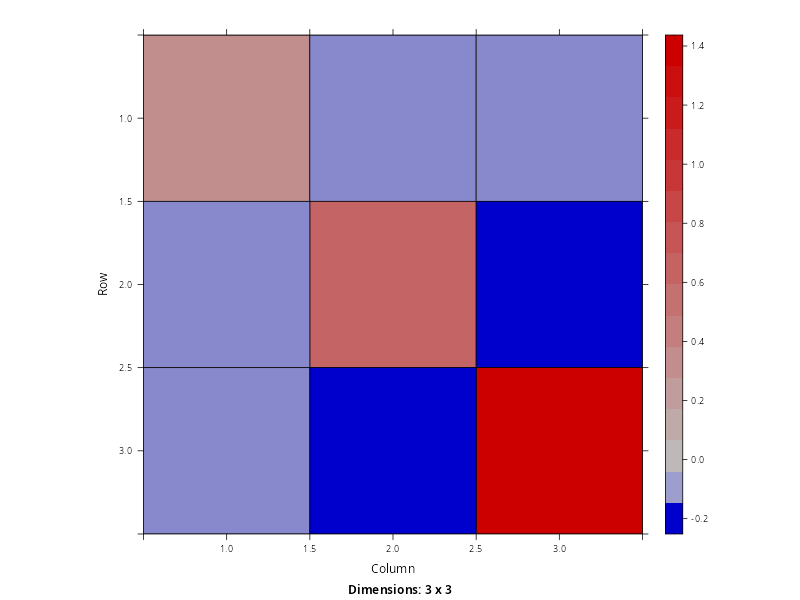

In [7]:
gls.mod <- gls(score ~ time, correlation=corCompSymm(form= ~1|id), weights=varIdent(form= ~1|time), data=selfesteem.long)

Sigma.1 <- getVarCov(gls.mod, individual='1')
print(Sigma.1)
image(as(Sigma.1, "Matrix"))

So, here we can see that we have created a variance-covariance matrix where *both* the diagonal and off-diagonal elements are not different. However, this has been achieved using only a *single* correlation parameter. So, in reality, the correlation between the repeated measurements remains *fixed*. We can see this by converting the variance-covariance matrix into a correlation matrix, using the `cov2cor()` function 

In [8]:
print(cov2cor(Sigma.1))

Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  1.00000 -0.15534 -0.15534
[2,] -0.15534  1.00000 -0.15534
[3,] -0.15534 -0.15534  1.00000
  Standard Deviations: 1 1 1 


So, the only reason the covariance is *different* is because the correlation is being scaled differently by the different variances. So do not be mislead. This structure is exactly what you would get from allowing heterogeneity of variance, even with a fixed correlation. So despite appearances, this is still quite a *restrictive structure*.

In order to allow the correlations to *actually differ* between the repeated measurements, we need to use the `corSymm()` structure. This specifies an *unstructured* symmetric covariance matrix, where each off-diagonal element can be *any value*. This allows the data to determine the magnitude and direction of each individual correlation between the repeated measurements.

Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.76920 -0.23823  0.21441
[2,] -0.23823  0.76920 -0.33831
[3,]  0.21441 -0.33831  0.76920
  Standard Deviations: 0.87704 0.87704 0.87704 


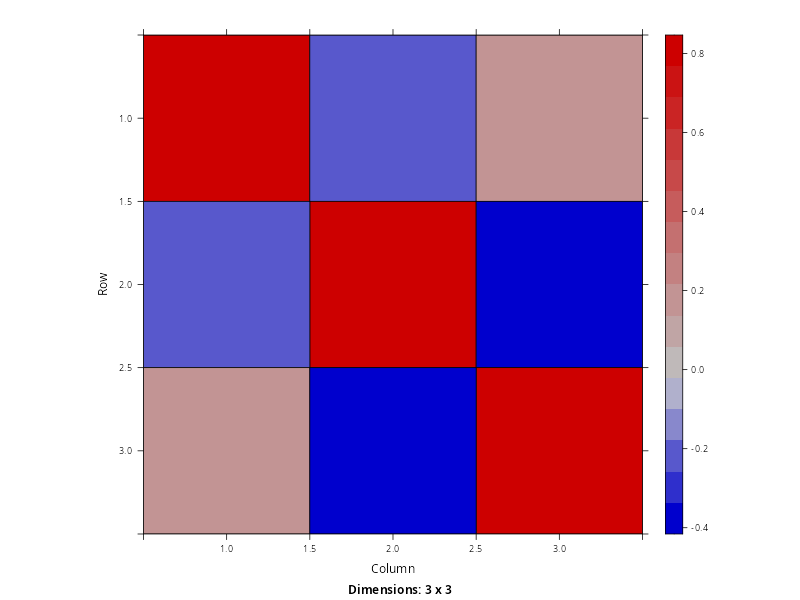

In [9]:
gls.mod <- gls(score ~ time, correlation=corSymm(form= ~1|id), data=selfesteem.long)

Sigma.1 <- getVarCov(gls.mod, individual='1')
print(Sigma.1)
image(as(Sigma.1, "Matrix"))

This time, we have kept the variances *fixed* but have allowed the *correlation* to change between the repeated measurements.

3 x 3 Matrix of class "dsyMatrix"
           [,1]       [,2]       [,3]
[1,]  0.3044901 -0.1272857  0.2273559
[2,] -0.1272857  0.7448897 -0.5157849
[3,]  0.2273559 -0.5157849  1.3055278


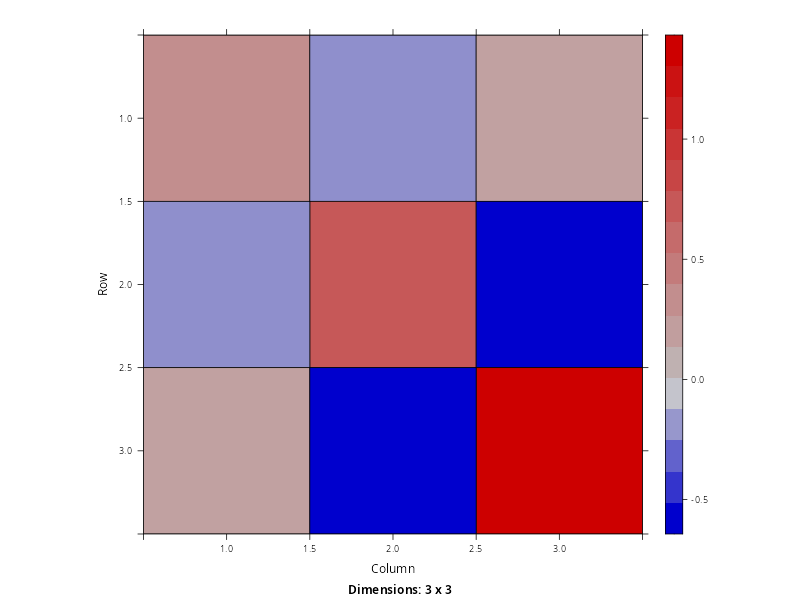

In [10]:
gls.mod <- gls(score ~ time, correlation=corSymm(form= ~1|id), weights=varIdent(form= ~1|time), data=selfesteem.long)
Sigma.1 <- getVarCov(gls.mod, individual='1')
Sigma.1 <- as(Sigma.1, "Matrix")
print(Sigma.1)
image(Sigma.1)

## Comparing Covariance Structures

In [ ]:
gls.mod.1 <- gls(score ~ time, correlation=corCompSymm(form= ~1|id),                                  data=selfesteem.long, method='ML') # compound symmetry + homogeneity of variance
gls.mod.2 <- gls(score ~ time, correlation=corCompSymm(form= ~1|id), weights=varIdent(form= ~1|time), data=selfesteem.long, method='ML') # compound symmetry + heterogeneity of variance
gls.mod.3 <- gls(score ~ time, correlation=    corSymm(form= ~1|id),                                  data=selfesteem.long, method='ML') # general symmetric + homogeneity of variance
gls.mod.4 <- gls(score ~ time, correlation=    corSymm(form= ~1|id), weights=varIdent(form= ~1|time), data=selfesteem.long, method='ML') # general symmetric + heterogeneity of variance

anova(gls.mod.1, gls.mod.2, gls.mod.3, gls.mod.4)

          Model df      AIC      BIC    logLik   Test  L.Ratio p-value
gls.mod.1     1  5 83.60855 90.61453 -36.80427                        
gls.mod.2     2  7 83.04092 92.84930 -34.52046 1 vs 2 4.567627  0.1019
gls.mod.3     3  7 84.66271 94.47109 -35.33136                        
gls.mod.4     4  9 83.11777 95.72855 -32.55888 3 vs 4 5.544944  0.0625

The degrees of freedom here are a count of the number of parameters that need to be estimated. As each model has the same mean structure, there in always a single *intercept* parameter and two `time` parameters. The remaining count are those associated with the covariance structure. So, we can see that `gls.mod.1` has 2 covariance parameters corresponding to the constant variance and constant correlation. Both models 2 and 3 have 4 covariance parameters, corresponding to either 1 fixed variance and 3 free correlations, or 3 free variances and 1 fixed correlation. Finally, model 4 has 6 covariance parameters, corresponding to 3 free variances and 3 free correlations.

In terms of the inferential tests, these are computed as a *likelihood ratio*, but only between models that are *nested*. In other words, one model is a subset of another. In this example, this is only true of those models that share a correlation structure. So the tests here are based on assessing whether the additional flexibility added by allowing heterogeneity of variance is warranted. The $p$-value here is also based on asymptotic theory, so we have to be quite cautious in small samples. So, for our current purpose, the $p$-value here is not so useful, but could be if we were certain we wanted a specific correlation structure and our only remaining question was whether the additional `weights=` argument was needed.

So, in terms of actually deciding between these covariance structures, we turn to model comparisons procedures using the AIC and BIC. These were explored last semester as part of the [ANOVA workshop](https://github.com/PCHN63101-Advanced-Data-Skills/Model-Comparisons-ANOVA/blob/main/ANOVA-workshop.ipynb), so it may be worth quickly revising this before going any further. ...

In terms of choosing between AIC and BIC, we will favour BIC here because BIC is more focussed on the *data-generating process* than on *prediction*. It punishes complexity much harder than AIC, meaning the data really needs to suggest a complex structure is needed for BIC to allow it. This makes BIC more favourable in terms of developing a *parsimonious* model of the data-generating process.

Focussing just on BIC, we are looking for the model with the *smallest* values of BIC. In this example, it is the model with a *compound symmetric* correlation structure and *homogeneity of variance*. However, the *absolute* value of BIC is not of importance. What matters is the *difference*. Between the model with largest and smallest BIC, the change is $\Delta\text{BIC} = 95.73 - 90.61 = 5.11$. If we look back at the interpretation guidance we gave last semester for interpreting BIC (in the [ANOVA workshop](https://github.com/PCHN63101-Advanced-Data-Skills/Model-Comparisons-ANOVA/blob/main/ANOVA-workshop.ipynb)), a change of around 5 is considered *positive evidence favouring the lower-BIC model*. This is not super strong evidence, but it is suggesting that the additional complexity is *not warranted* in order to explain the data. All other comparisons indicate *smaller* changes in BIC, meaning that although the simplest covariance structure is supported, this is not a slam-dunk by any means. In this situation, we would likely use the simplest covariance structure, but we would be aware of the fact that the evidence in support of this structure is not overwhelming and that something more complex *could* be warranted if we had more data or repeated the experiment again.

## Assumptions and Visualisations

### Assumptions Plots

In [ ]:
plot.gls <- function(mod, timeseries=FALSE){

  w <- resid(mod, type="normalized")
  f <- fitted(mod)

  par(mfrow=c(2,2))

  # Residuals vs fitted
  plot(f, w, main='Residuals vs fitted')
  abline(h=0, lty=2)

  # Normal Q-Q
  qqnorm(w) 
  qqline(w)
  
  # Scale-Location
  plot(f, sqrt(abs(w)), main='Scale-Location')

  # Either plot of the ACF, or a visualisation of the marginal covariance structure
  if (timeseries==TRUE){
    acf(w)                                   
  } else {
    V <- getVarCov(mod)
    graphics::image(as.matrix(V)[nrow(V):1, ], main='Marginal covariance structure')
  }
}

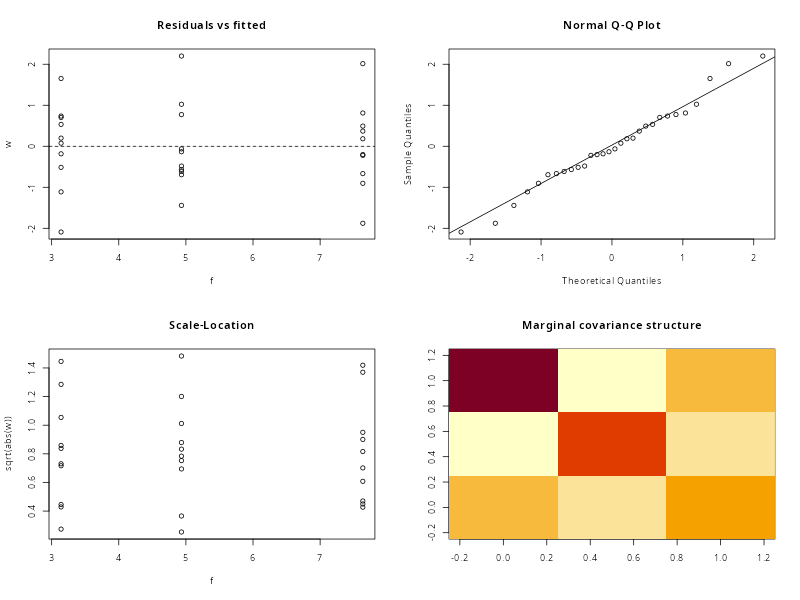

In [ ]:
plot.gls(gls.mod.4)

### Visualising the Model

## Inference Using `gls()`

### Coefficient Tests
... The key is understanding that the `gls()` function is designed to act *as if* we were using GLS instead of FGLS. So irrespective of whether we *give* `gls()` a covariance structure or *estimate* a covariance structure, the function will act the same way. This is **Option 1a** from earlier in the lesson: assume $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$ and *ignore* the problem entirely. Once we understand this, the behaviour of `gls()` makes complete sense.

### Omnibus Tests

### Follow-up Tests

## Viewing the Complete Covariance Structure

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.